In [31]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import math
import csv
from scipy.optimize import minimize, Bounds

V_const = 10**14

class Const:
    #eta = 1e-3
    #rho_f = 1000

    eta = 0.36e-3 # Viscosity of acetone
    rho_f = 789  # Density of acetone
    # K = 10e-6
    T = 293
    k_b = scipy.constants.k
    runs = 10000
    # V = 10**6
    BaTi_density = 4200


high_pass = 100
bin_number = 30
velocity_order = 8
filename = r"C:\Users\mct2723\Desktop\Dielectric Data\Third Good Set\10"
offset = 237
num_files = 1
traces_per_file = 5
sampling_rate = 200000000
tikonov = True
stop = .5e-3

In [32]:
def MSD_fitting_func(t,m, K, r, V):
    trap_const = K
    use_mass = m
    m_f = 4/3*np.pi*r**3*Const.rho_f
    t_k = (6 * np.pi * r * Const.eta)/trap_const
    t_f = (Const.rho_f*r**2)/Const.eta
    t_p = m/(6 * math.pi * r * Const.eta)
    # find roots
    # a * z^4 + b * z^3 + c * z^2 + d * z + e = 0
    a = t_p
    b = -1*np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    # Coefficients array for the polynomial equation
    coefficients = [a, b, c, d, e]

    # Find the roots
    roots = np.roots(coefficients)

    term_1 = scipy.special.erfcx(roots[0]*np.sqrt(t)) / (roots[0]*(roots[0] - roots[1])*(roots[0] - roots[2])*(roots[0] - roots[3]))
    term_2 = scipy.special.erfcx(roots[1]*np.sqrt(t)) / (roots[1]*(roots[1] - roots[0])*(roots[1] - roots[2])*(roots[1] - roots[3]))
    term_3 = scipy.special.erfcx(roots[2]*np.sqrt(t)) / (roots[2]*(roots[2] - roots[1])*(roots[2] - roots[0])*(roots[2] - roots[3]))
    term_4 = scipy.special.erfcx(roots[3]*np.sqrt(t)) / (roots[3]*(roots[3] - roots[1])*(roots[3] - roots[2])*(roots[3] - roots[0]))

    D = Const.k_b*Const.T / (6*np.pi*Const.eta*a)

    return np.real(V*(2*Const.k_b*Const.T / trap_const+ 2*Const.k_b*Const.T/(m)*(term_1+term_2+term_3+term_4)))


def save_results_to_csv(traces, output_file):

    trace_headers = [f"Trace {i + 1}" for i in range(len(traces))]

    # Write data to CSV
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)

        writer.writerow(trace_headers)

        max_trace_length = max(len(trace) for trace in traces)

        for i in range(max_trace_length):
            row = []
            for trace in traces:
                if i < len(trace):
                    row.append(trace[i])
                else:
                    row.append("")
            writer.writerow(row)

    print(f"Data saved to {output_file}")

def MSD_fitting_const_rho(t, MSD_data, K_guess, a_guess, V_guess, m_guess, bounds=None):
    initial_guess = [V_guess, a_guess, K_guess]
    def least_squares_func(x):
        # Fit for mass only, using K and a as constants
        K = x[2] / 10**6

        V = x[0] *V_const
        a = x[1]*10**-6
        m = 4/3*np.pi*a**3*(Const.BaTi_density + Const.rho_f/2)
        msd_model = MSD_fitting_func(t, m, K, a, V)
        # Least squares: minimize the sum of squared differences
        print_negative_indices(np.real(MSD_data), "data")
            # print(f"K: {K}, V: {V}, a: {a}, m: {m} ")
        print_negative_indices(np.real(msd_model), "model")
            # print(f"K: {K}, V: {V}, a: {a}, m: {m} ")

        return np.sum((np.log(np.real(MSD_data)) - np.log(np.real(msd_model))) ** 2)

    optimal_parameters = scipy.optimize.minimize(least_squares_func, initial_guess, bounds=bounds, method="Nelder-Mead", options={'maxiter':10000,'xatol': 1e-13, 'fatol': 1e-13})
    return optimal_parameters

def print_negative_indices(arr, str):
    """Prints the indices of negative elements in an array.

    Args:
        arr: A list of numbers.
    """
    for i in range(len(arr)):
        if arr[i] < 0:
            print(f"index {i} is less than zero." + " " + str)
            return True


In [33]:
import os
from nptdms import TdmsFile

def check_and_load_or_process(offset, *args,):
    results = process_folder(offset, *args)
    # Returns a list of args, and traces
    return results

def process_folder(offset, folder_name, data_col, num_traces, traces_per):
    results = []
    for i in range(num_traces):
        print("Reading ", folder_name, str(i))
        print("data_col ", data_col)
        for j in range(traces_per):
            result = process_file(folder_name, i, data_col, j, offset=offset)
            if result:
                results.append(result)
    return results

def process_file(folder_name, trace_num, data_col, trace_idx, offset):
    trace_num = trace_num + offset
    file_path = os.path.join(folder_name, "iter_" + str(trace_num) + ".tdms")
    series, args = read_tdms_file(file_path, data_col, trace_idx)

    return {
        "series": series,
        "args": args
    }
def read_tdms_file(file_path, data_col, trace_idx):
    tdms_file = TdmsFile.read(file_path)
    sample_rate = tdms_file["main"].properties.get("r", None)
    print("Sample rate is " + str(sample_rate))
    series = tdms_file["main"][data_col + "_" + str(trace_idx)]
    track_len = len(series.data)
    config_args = {
        "sampling_rate": sample_rate,
        "track_len": track_len
    }

    return series[:], config_args

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size

    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    ret = np.mean(series.reshape(-1, bin_size), axis=1)
    return ret

def compute_stationary_msd(time_trace, dt):
    n = len(time_trace)
    msd = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(1, n, 1) * dt  # Calculate lag times

    for tau in np.array(range(n-1))+1:
        displacements = time_trace[tau:] - time_trace[:n - tau]
        msd[tau] = np.mean(displacements**2)
    msd[0] = np.average(time_trace**2)
    return msd[1:], lag_times

def compute_stationary_msd_fast(time_trace, dt):
    n = len(time_trace)
    msd = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(1, n, 1) * dt  # Calculate lag times

    for tau in np.array(range(1, n, 1)):
        displacements = time_trace[tau:] - time_trace[:n - tau]
        msd[tau] = np.mean(displacements**2)
    msd[0] = np.average(time_trace**2)
    return msd[1:], lag_times


def j_msd(signal, lags):
    MSDs = np.zeros(len(lags))
    ls = lags
    for i in range(1, len(ls)):
        counter = 0
        #for j in range(len(signal)-ls[len(ls)-1]-1):
        for j in range(10000):
            MSDs[i] += (signal[j] - signal[ls[i]+j])**2
            counter+=1

        MSDs[i] /= counter
    MSDs[0] = np.average(signal**2)
    return MSDs

def low_freq_fit(f):
    C = 1 / (10**-6*1000)
    x_c = 1j*f*2*np.pi
    #A = 4000
    A = 4.66255013e+03
    Sallen_key = x_c**2 / (x_c**2 + A*x_c + 15909216.44677893/3)
    RC_high_pass = x_c / (x_c +C)
    return np.abs(Sallen_key)

    # df = pd.read_csv(r"C:\Users\mcthu\OneDrive\Desktop\Lab Data\no_filter_response.txt")
    # freqs = np.array(df[df.keys()[0]])
    # print(freqs.max())
    # print(freqs.min())
    # r = np.array(df[df.keys()[1]])
    # # Debug: Check for zeros in r
    # if np.any(r == 0):
    #     print("Warning: Interpolation data contains zeros in the response column.")
    #
    # interpolation = scipy.interpolate.interp1d(freqs, r, fill_value = "extrapolate")
def apply_transfer(freq, response):
    def low_freq_fit2(f):
        C = 1 / (10**-6*1000)
        x_c = 1j*f*2*np.pi
        #A = 4000
        A = 4.66255013e+03
        Sallen_key = x_c**2 / (x_c**2 + A*x_c + 15909216.44677893/3)
        RC_high_pass = x_c / (x_c +C)
        return np.abs(Sallen_key)

    print(low_freq_fit2(freq)[low_freq_fit2(freq) <= 0])

    ret = np.concatenate([[1], np.array(response[1:]) / low_freq_fit2(freq)[1:]])
    return ret



step time is1.5e-07
Reading  C:\Users\mct2723\Desktop\Dielectric Data\Third Good Set\10 0
data_col  X
Sample rate is 200000000.0
Sample rate is 200000000.0
Sample rate is 200000000.0
Sample rate is 200000000.0
Sample rate is 200000000.0


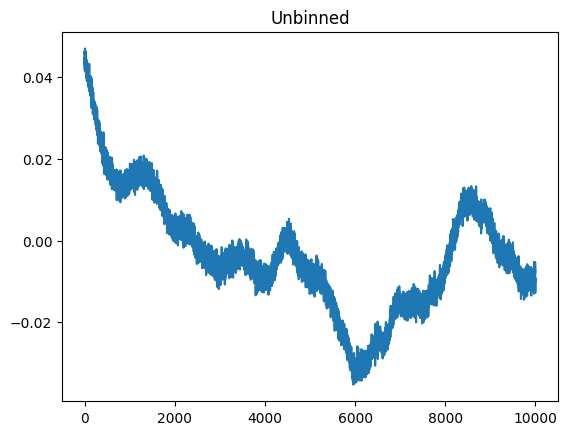

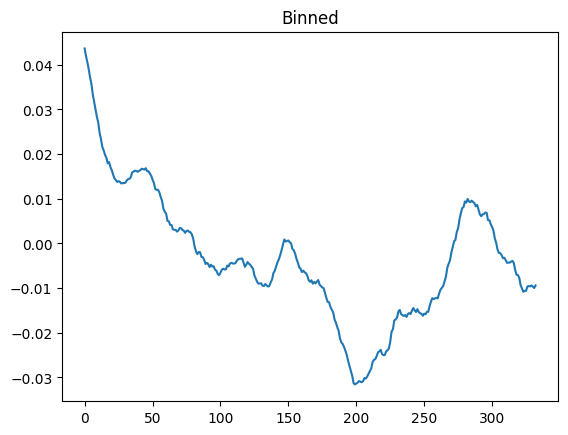

In [34]:


print("step time is" + str(bin_number/sampling_rate))

traces = check_and_load_or_process(offset, filename, "X", num_files, traces_per_file)
times = np.arange(0, len(traces[0]['series']))* (1/sampling_rate)

transfered_traces = []

if tikonov:
    lda = np.abs(low_freq_fit(high_pass))
    for trace in traces:
        # apply the transfer and convert back
        freq_domain_data = scipy.fft.fft(trace['series'])
        frequencies = scipy.fft.fftfreq(len(trace['series']), times[1] - times[0])
        transfer = low_freq_fit(frequencies)

        freq_domain_data_transfer = (freq_domain_data*np.conj(transfer))/(np.real(transfer)**2 + np.imag(transfer)**2 + lda**2)
        data = np.fft.ifft(freq_domain_data_transfer)

        transfered_traces.append(np.real(data))
else:
    for trace in traces:
        # apply the transfer and convert back
        freq_domain_data = scipy.fft.fft(trace['series'])
        frequencies = scipy.fft.fftfreq(len(trace['series']), times[1] - times[0])
        transfer_f = apply_transfer(frequencies, freq_domain_data)
        trace_out = np.fft.ifft(transfer_f)

        transfered_traces.append(np.real(trace_out))

binned_traces = []

plt.plot(transfered_traces[0][:10000])
plt.title("Unbinned")
plt.show()

for trace in transfered_traces:
    series = bin_data(trace, bin_number)
    binned_traces.append(series)

plt.plot(binned_traces[0][:int(10000/bin_number)])
plt.title("Binned")
plt.show()



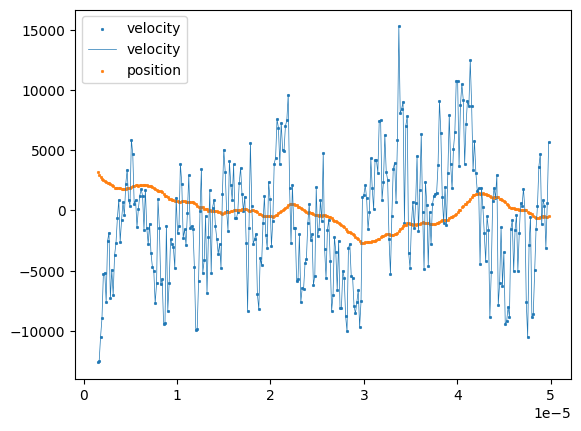

Data saved to ..\data\\barium_titanate_in_acetone_position_bin30.csv
Data saved to ..\data\\barium_titanate_in_acetone_velocity_bin30.csv


In [35]:
time = np.arange(len(binned_traces[0]))*bin_number/sampling_rate

from findiff import Diff

def get_velocity_higher_order(data, time, order):
    der = Diff(0, time[1] - time[0], acc = order)
    return der(data)


def get_velocity_centered_full(position, dt):
    velocity = np.zeros_like(position)

    # Use forward difference at the first point
    velocity[0] = (position[1] - position[0]) / dt

    # Use centered difference for the middle points
    velocity[1:-1] = (position[2:] - position[:-2]) / (2 * dt)

    # Use backward difference at the last point
    velocity[-1] = (position[-1] - position[-2]) / dt

    return velocity

velocity_traces = []
for trace in binned_traces:
    # velocity = get_velocity_centered_full(trace, bin_number/sampling_rate)
    velocity = get_velocity_higher_order(trace, time, velocity_order)
    velocity_traces.append(velocity)

plt.scatter(time[10:int(10000/bin_number)], velocity_traces[0][10:int(10000/bin_number)], label = "velocity", linewidth=.5, s=3)
plt.plot(time[10:int(10000/bin_number)], velocity_traces[0][10:int(10000/bin_number)], label = "velocity", linewidth=.5)
plt.legend()

plt.scatter(time[10:int(10000/bin_number)], binned_traces[0][10:int(10000/bin_number)]*100000 - np.mean(binned_traces[0][10:int(10000/bin_number)]*100000), label = "position", linewidth=.5, s=3)
plt.legend()
plt.show()

# We now want to save off three files
# The voltage to meter converted position and velocity trace, and the non voltage to meter converted position traces

filenames_and_data = {f"barium_titanate_in_acetone_position_bin{bin_number}": binned_traces,
                      f"barium_titanate_in_acetone_velocity_bin{bin_number}": velocity_traces}

for filename in filenames_and_data:
    output_path = r"..\data\\"
    output_file = f"{filename}.csv"
    file_path = output_path + output_file

    save_results_to_csv(filenames_and_data[filename], file_path)

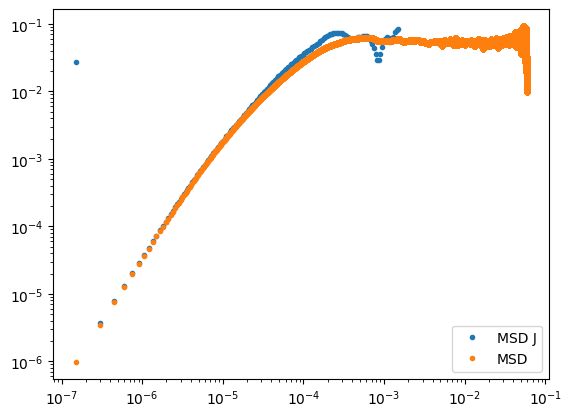

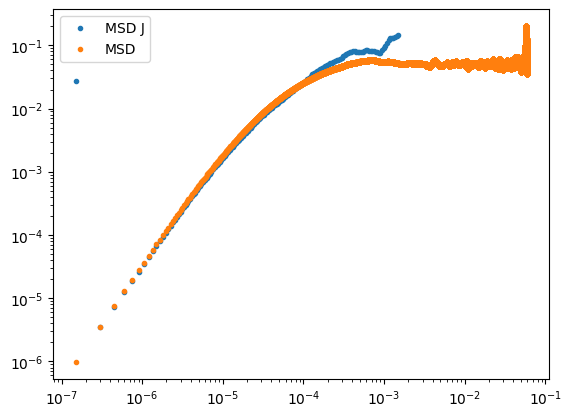

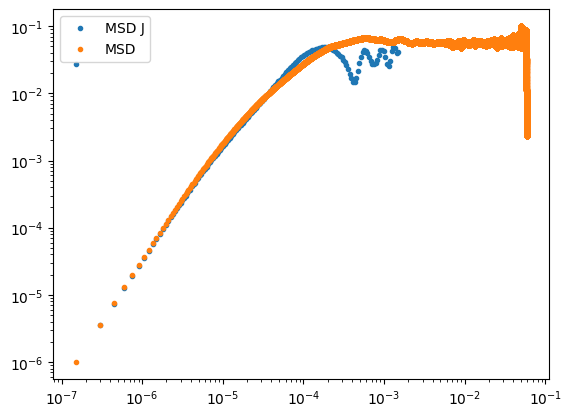

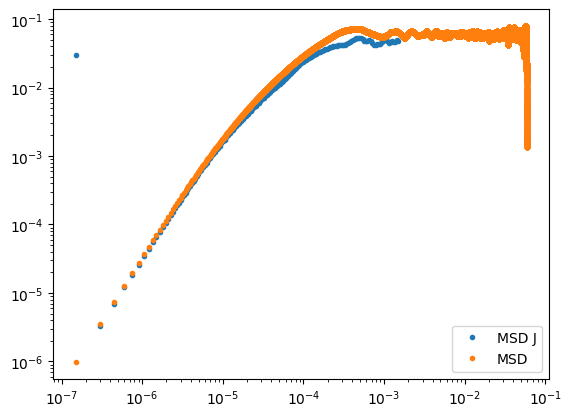

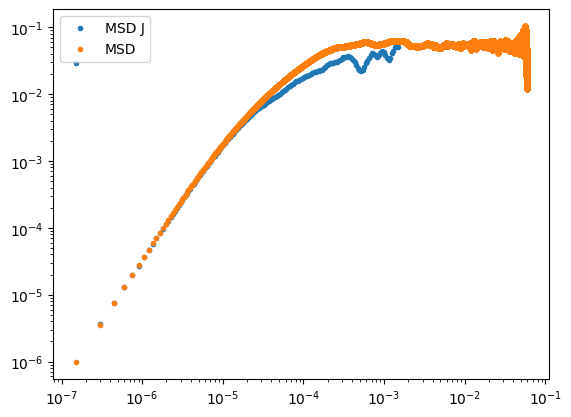

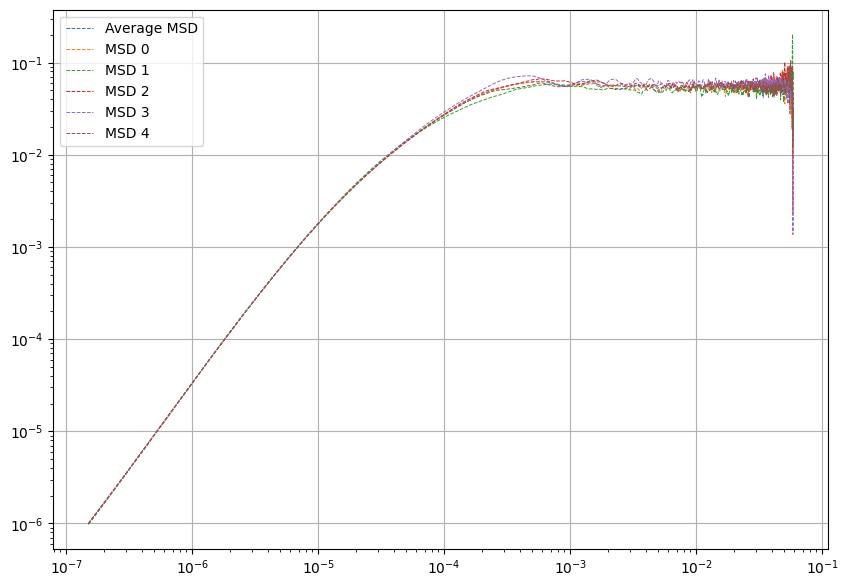

In [37]:
series_percent = 70

all_msd = []

for series in binned_traces:
    msd, lag_times = compute_stationary_msd(series[:int(len(series)*series_percent/100)], bin_number/sampling_rate)

    final_power = 4
    powers = np.linspace(0, final_power, 200)
    ls = np.array( np.floor(10**powers), dtype = np.int64)
    ls = np.unique(ls)
    msd_j = j_msd(series, ls)
    plt.plot(ls * bin_number / sampling_rate, msd_j, ".", label = "MSD J")
    plt.plot(lag_times, msd, ".", label = "MSD")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.show()
    all_msd.append(msd)

avg_msd = np.mean(all_msd, axis=0)

plt.figure(figsize=(10, 7))
plt.plot(lag_times, avg_msd, linewidth=.7, linestyle="dashed",label='Average MSD')

for i in range(len(all_msd)):
    plt.plot(lag_times, all_msd[i], linewidth=.7, linestyle="dashed",label=f'MSD {i}')

plt.legend()
plt.xscale("log")
plt.yscale("log")
# plt.xlim(right = 3e-6)
plt.grid(True)
plt.show()

2000


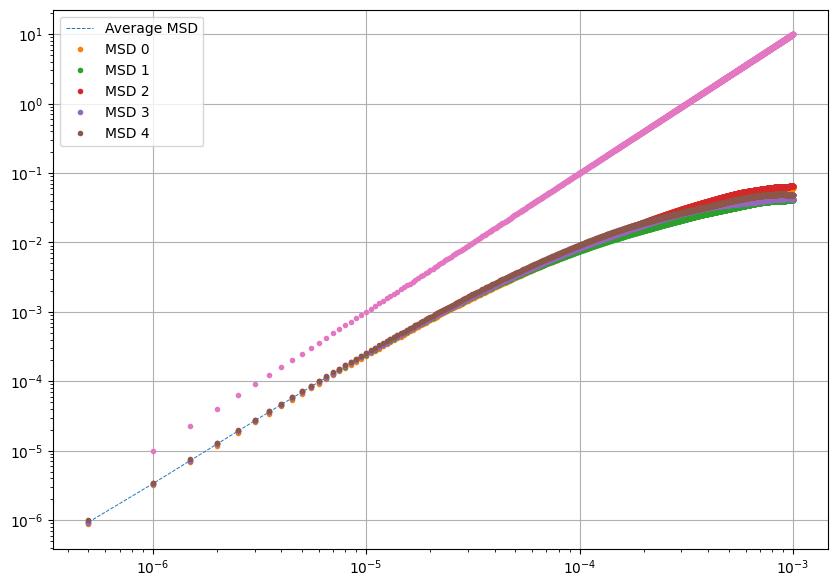

In [20]:
# CUT THE MSD DOWN TO A REASONABLE SIZE
max_len = int(stop*sampling_rate/bin_number)
print(max_len)
lag_times_ = lag_times[:max_len]
avg_msd_ = avg_msd[:max_len]
all_msd_ = []

for i in range(len(all_msd)):
    all_msd_.append(all_msd[i][:max_len])

plt.figure(figsize=(10, 7))
plt.plot(lag_times_, avg_msd_, linewidth=.7, linestyle="dashed",label='Average MSD')

for i in range(len(all_msd)):
    plt.plot(lag_times_, all_msd_[i], ".", linewidth=.7,label=f'MSD {i}')

plt.plot(lag_times_[1:], lag_times_[1:]**2*1e7, ".")
plt.legend()
plt.xscale("log")
plt.yscale("log")
# plt.ylim(top=2e-4, bottom=1e-4)
plt.grid(True)
plt.show()


v is 305694972781555.2, a is 2.60010705269715e-06, m is 3.3829887459807266e-13, K is 3.590544394548893e-05
v is 269593579123486.25, a is 2.430110586541235e-06, m is 2.761881095227391e-13, K is 5.4381770430166956e-05
v is 388612122662515.9, a is 2.7655518228688675e-06, m is 4.0707297220940836e-13, K is 4.31187763322765e-05
v is 371868400844939.44, a is 2.7493059551521764e-06, m is 3.999411430481683e-13, K is 7.064702540507434e-05
v is 417322905757185.06, a is 2.8222382399589173e-06, m is 4.326212833557688e-13, K is 7.013814940561201e-05
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.009741461828136982
             x: [ 3.057e+00  2.600e+00  3.591e+01]
           nit: 261
          nfev: 538
 final_simplex: (array([[ 3.057e+00,  2.600e+00,  3.591e+01],
                       [ 3.057e+00,  2.600e+00,  3.591e+01],
                       [ 3.057e+00,  2.600e+00,  3.591e+01],
                       [ 3.057e+00,  2.600e+00,  3.59

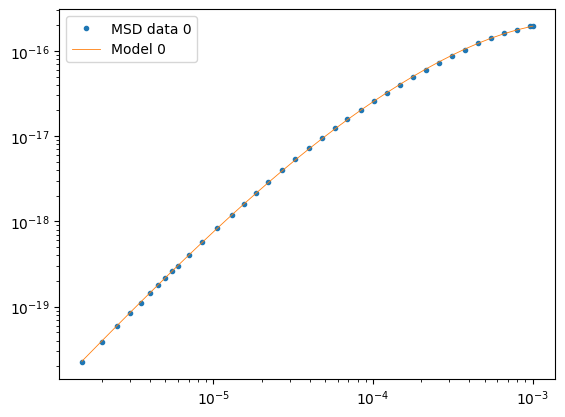

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.054742204550329396
             x: [ 2.696e+00  2.430e+00  5.438e+01]
           nit: 290
          nfev: 580
 final_simplex: (array([[ 2.696e+00,  2.430e+00,  5.438e+01],
                       [ 2.696e+00,  2.430e+00,  5.438e+01],
                       [ 2.696e+00,  2.430e+00,  5.438e+01],
                       [ 2.696e+00,  2.430e+00,  5.438e+01]]), array([ 5.474e-02,  5.474e-02,  5.474e-02,  5.474e-02]))


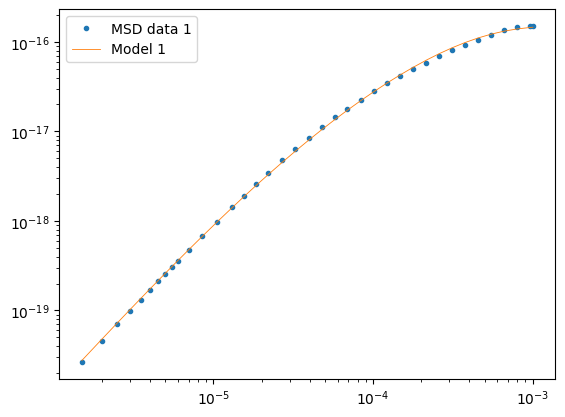

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.01268625303481867
             x: [ 3.886e+00  2.766e+00  4.312e+01]
           nit: 261
          nfev: 539
 final_simplex: (array([[ 3.886e+00,  2.766e+00,  4.312e+01],
                       [ 3.886e+00,  2.766e+00,  4.312e+01],
                       [ 3.886e+00,  2.766e+00,  4.312e+01],
                       [ 3.886e+00,  2.766e+00,  4.312e+01]]), array([ 1.269e-02,  1.269e-02,  1.269e-02,  1.269e-02]))


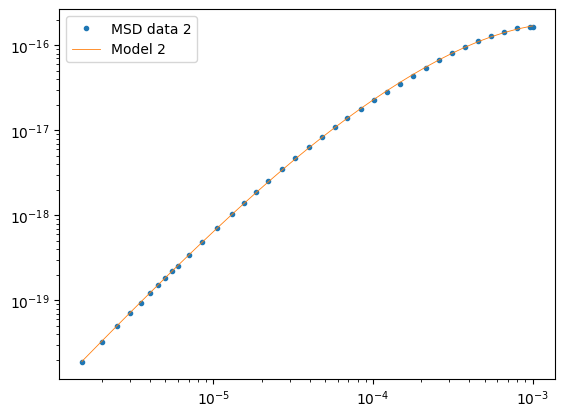

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.003636582260402763
             x: [ 3.719e+00  2.749e+00  7.065e+01]
           nit: 274
          nfev: 570
 final_simplex: (array([[ 3.719e+00,  2.749e+00,  7.065e+01],
                       [ 3.719e+00,  2.749e+00,  7.065e+01],
                       [ 3.719e+00,  2.749e+00,  7.065e+01],
                       [ 3.719e+00,  2.749e+00,  7.065e+01]]), array([ 3.637e-03,  3.637e-03,  3.637e-03,  3.637e-03]))


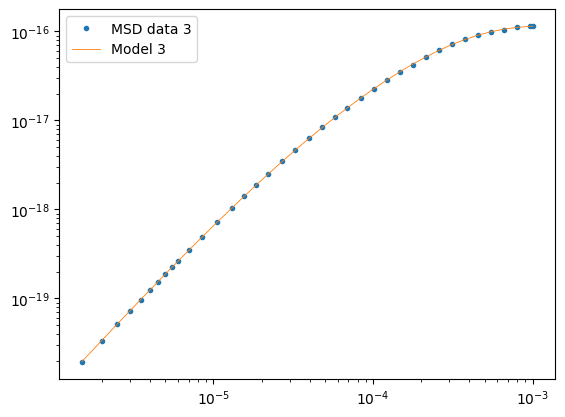

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.02193460850055915
             x: [ 4.173e+00  2.822e+00  7.014e+01]
           nit: 267
          nfev: 537
 final_simplex: (array([[ 4.173e+00,  2.822e+00,  7.014e+01],
                       [ 4.173e+00,  2.822e+00,  7.014e+01],
                       [ 4.173e+00,  2.822e+00,  7.014e+01],
                       [ 4.173e+00,  2.822e+00,  7.014e+01]]), array([ 2.193e-02,  2.193e-02,  2.193e-02,  2.193e-02]))


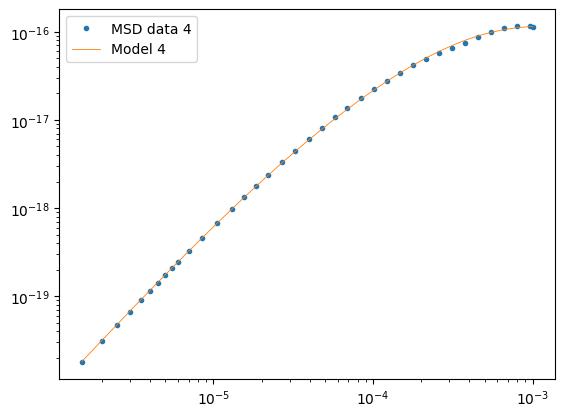

MEAN a: 2.6734627314436694e-06 STD a: 1.421042359037659e-07 Mean k: 5.4838233103723734e-05 std k: 1.4000070595338962e-05 mean V: 350618396233936.4 std V: 54640118039950.12


In [21]:
# Fit again without first two data points
# WEIGHT THE HIGH FREQ DATA MORE HEAVILY ...

def remove_data_points_and_first_two(lagtimes_, msd_, num_points):
    bottom = 10
    powers = np.linspace(1, 5, num_points)
    ls = np.array(np.floor(10**powers), dtype=np.int64) * bin_number / sampling_rate
    mask = ls >= lagtimes_[bottom]
    ls_f = ls[mask]

    lagtimes = np.array(lagtimes_)
    msd = np.array(msd_)

    remove = [0,1]
    start = bottom

    for i in range(len(ls_f)-1):
        if lagtimes[start] < ls_f[i]:
            if start > len(lagtimes) - 2:
                break
            start += 1
            while start < len(lagtimes)-1 and lagtimes[start] < ls_f[i]:
                remove.append(start)
                start += 1

    l_ret = np.delete(lagtimes, remove)
    m_ret = np.delete(msd, remove)
    return l_ret, m_ret

down_lag_2 = 0
all_down_msd_2 = []

for msd in all_msd_:
    down_lag_2, down_msd = remove_data_points_and_first_two(lag_times_, msd, 50)
    all_down_msd_2.append(down_msd)

# FIT AGAIN With Log sampling

individual_params3 = []
inndividual_scaled_msd3 = []
individual_fits3 = []

all_a = []
all_v = []
all_m = []
all_k = []

bounds = [(1e-10, None), (1e-10, None),(1e-10, None)]
for msd in all_down_msd_2:
    params1 = MSD_fitting_const_rho(down_lag_2, msd, 1, 3, 1, 1,  bounds = bounds)
    p1 = params1.x
    V1 = p1[0] *V_const
    a1 = p1[1]*10**-6
    m1 = 4/3*np.pi*a1**3*(Const.BaTi_density + Const.rho_f / 2)
    K1 = p1[2] * 10**-6
    print(f"v is {V1}, a is {a1}, m is {m1}, K is {K1}")

    all_v.append(V1)
    all_a.append(a1)
    all_m.append(m1)
    all_k.append(K1)

    scaled_msd_data1 = msd/V1
    final_msd_fit1 = MSD_fitting_func(down_lag_2, m1, K1, a1, 1)

    individual_params3.append(params1)
    individual_fits3.append(final_msd_fit1)
    inndividual_scaled_msd3.append(scaled_msd_data1)


for i in range(len(individual_fits3)):
    plt.plot(down_lag_2, inndividual_scaled_msd3[i], ".",linewidth=.6, label=f'MSD data {i}')
    plt.plot(down_lag_2, individual_fits3[i], linewidth=.6, label=f'Model {i}')
    print( str(individual_params3[i]))

    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.show()
#
# plt.xscale("log")
# plt.yscale("log")
# plt.legend()
plt.show()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
import numpy as np

print(f"MEAN a: {np.mean(all_a)} STD a: {np.std(all_a)} Mean k: {np.mean(all_k)} std k: {np.std(all_k)} mean V: {np.mean(all_v)} std V: {np.std(all_v)}")


In [22]:

indices_to_remove = []  # remove elements at these indices
new_a = [x for i, x in enumerate(all_a) if i not in indices_to_remove]
new_v = [x for i, x in enumerate(all_v) if i not in indices_to_remove]
new_k = [x for i, x in enumerate(all_k) if i not in indices_to_remove]

a_s = np.mean(new_a)
k_s = np.mean(new_k)
v_s = np.mean(new_v)

print(f"MEAN a: {np.mean(new_a)} STD a: {np.std(new_a)} Mean k: {np.mean(new_k)} std k: {np.std(new_k)} mean V: {np.mean(new_v)} std V: {np.std(new_v)}")


MEAN a: 2.6734627314436694e-06 STD a: 1.421042359037659e-07 Mean k: 5.4838233103723734e-05 std k: 1.4000070595338962e-05 mean V: 350618396233936.4 std V: 54640118039950.12


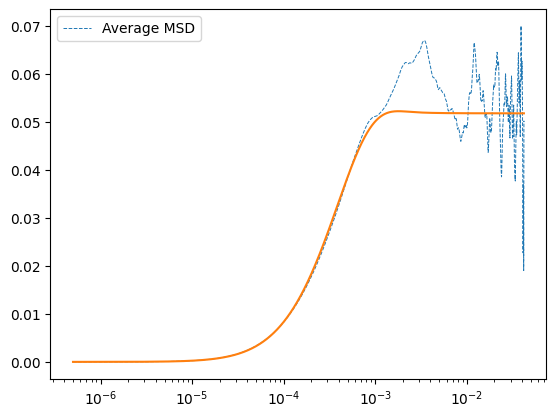

In [23]:
plt.plot(lag_times, avg_msd, linewidth=.7, linestyle="dashed",label='Average MSD')
_m = 4/3 *np.pi *a_s**3*4200 + 2/3 *np.pi *a_s**3*789
plt.plot(lag_times, MSD_fitting_func(lag_times, _m, k_s, a_s, v_s))
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

200000000
100


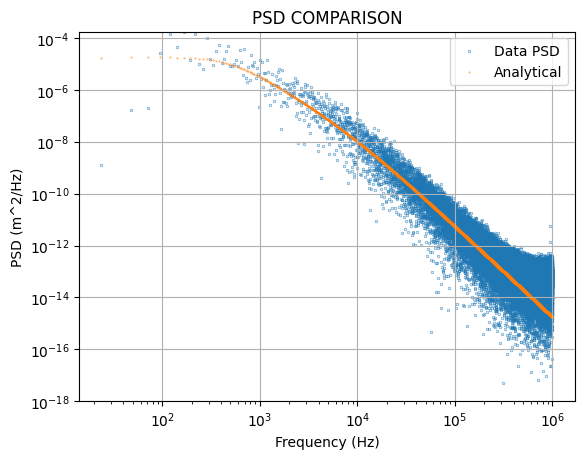

200000000
100


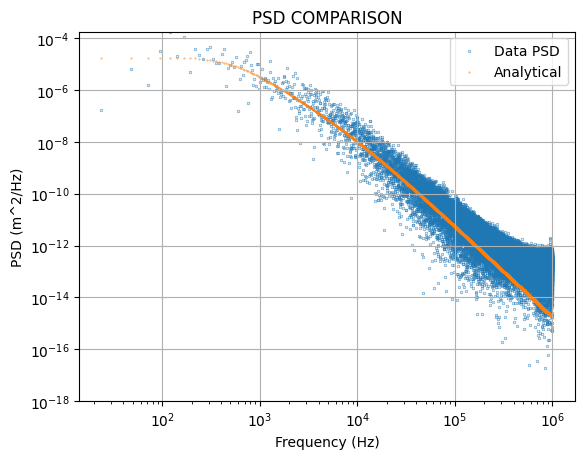

200000000
100


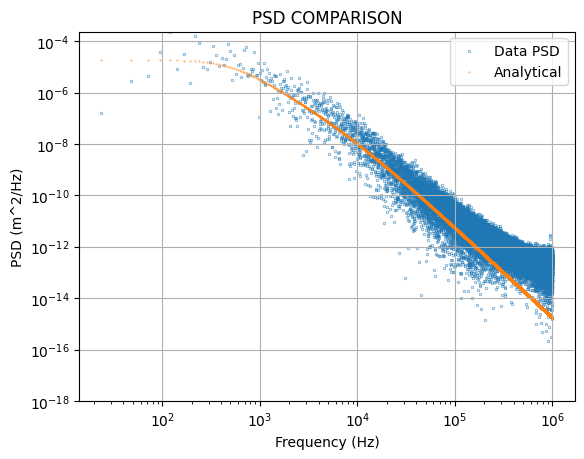

200000000
100


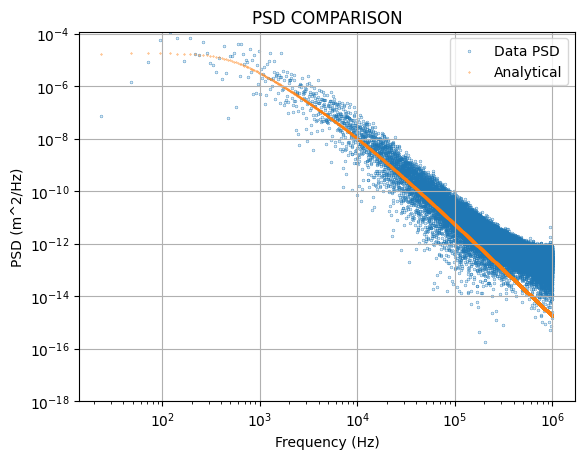

200000000
100


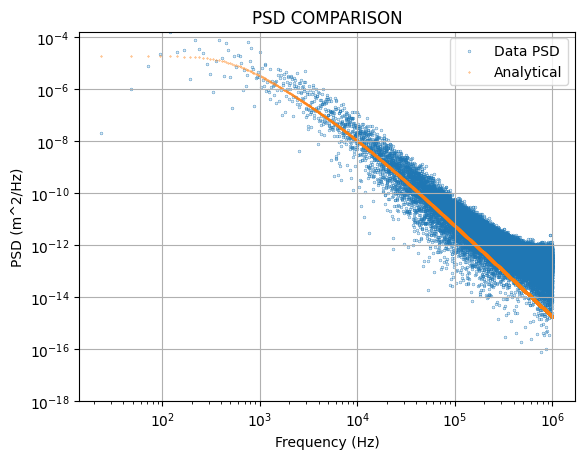

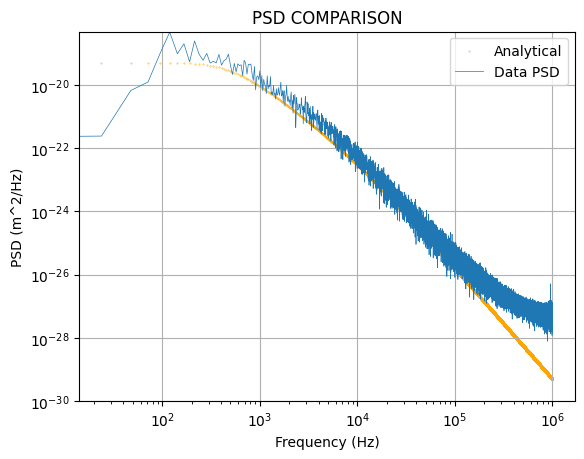

In [24]:
# #Remove
# a_s = 2.675e-6
# k_s = 1.113e-4
# v_s = 3.473e14

def PSD_standalone(omega):
    # This is the PSD we look to fit.  We fit for 3 parameters
    # Namely, we fit for the trap strength K, the radius of the particle a, and the voltage to position conversion V
    mass_total = 4/3*np.pi*a_s**3*Const.BaTi_density + 2/3*np.pi*a_s**3*Const.rho_f
    gamma_s = 6 * math.pi * a_s * Const.eta
    tau_f = Const.rho_f * a_s ** 2 / Const.eta
    numerator = 2 * Const.k_b * Const.T * gamma_s * (1 + np.sqrt((1 / 2) * omega * tau_f))
    denominator = (mass_total*((k_s/mass_total)-omega**2) - omega * gamma_s * np.sqrt((1 / 2) * omega * tau_f)) ** 2 + omega ** 2 * gamma_s ** 2 * (
            1 + np.sqrt((1 / 2) * omega * tau_f)) ** 2
    return numerator / denominator

psds = []
frequency = 0
for trace in binned_traces:
    frequency, psd = scipy.signal.periodogram(trace, fs=sampling_rate/bin_number, scaling="density")
    print(sampling_rate)
    print(bin_number)
    psds.append(psd)
    plt.scatter(frequency, psd, s=.1, label="Data PSD", linewidth=2)
    plt.scatter(frequency, v_s*PSD_standalone(2*math.pi*frequency), s=.1, label="Analytical")

    plt.ylim(bottom=1e-18)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD (m^2/Hz)")
    plt.xscale('log')
    plt.yscale('log')
    plt.grid()
    plt.title("PSD COMPARISON")
    plt.legend()
    plt.show()
psd = np.mean(psds, axis=0)

psd_analytical = v_s*PSD_standalone(2*math.pi*frequency)

plt.scatter(frequency, psd_analytical/v_s, s=.1, color = 'orange', label="Analytical")
plt.plot(frequency, psd/v_s,  label="Data PSD", linewidth=.5)
plt.ylim(bottom=1e-30)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (m^2/Hz)")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.title("PSD COMPARISON")
plt.legend()
plt.show()

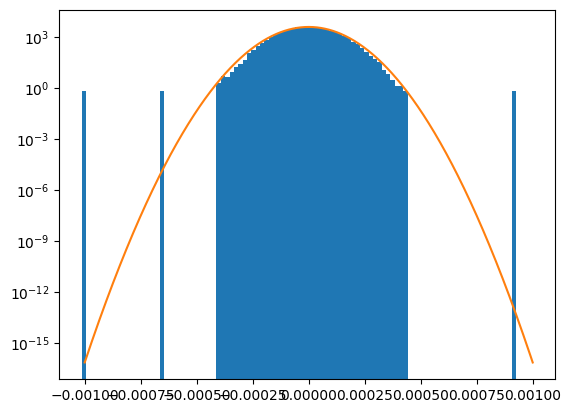

0.9401225712003569


In [25]:
mass_total = 4/3*np.pi*a_s**3*Const.BaTi_density + 2/3*np.pi*a_s**3*Const.rho_f
vs = np.linspace(-1*10**-3, 1*10**-3, 1000)
expected =( 1 / np.sqrt(2*np.pi) * np.sqrt(mass_total / (Const.k_b*Const.T))*np.exp(-vs**2 / (2*Const.k_b*Const.T / mass_total)))

plt.hist(velocity_traces[0]/np.sqrt(v_s), bins = 100, density = True)
# plt.hist(velocity2 / v, bins = 100, density = True)
plt.plot(vs, expected)
plt.yscale("log")
plt.show()

_m = 4/3 *np.pi *a_s**3*4200 + 2/3 *np.pi *a_s**3*789
_temp = 293

print(np.std(velocity_traces[0]/np.sqrt(v_s))/np.sqrt(scipy.constants.k * _temp/_m))

In [26]:
print(f"This leaves us with \n a: {a_s} \n v: {v_s} \n k: {k_s} \n bin_number: {bin_number} \n sample_rate: {sampling_rate}")


This leaves us with 
 a: 2.6734627314436694e-06 
 v: 350618396233936.4 
 k: 5.4838233103723734e-05 
 bin_number: 100 
 sample_rate: 200000000
